In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
import nltk                                              # Natural Language Toolkit: https://www.nltk.org/
from nltk.corpus import stopwords                        # "мусорные" слова (стоп-слова): предлоги, союзы, часто используемые слова ...
from nltk.stem import PorterStemmer, SnowballStemmer     # приводить разные формы одного слова к одной
from nltk.tokenize import word_tokenize                  # разделять текст на слова
from nltk import ngrams, FreqDist                        # подсчитывать частоты слов

import string                                            # string.punctuation -- символы пунктуации
from wordcloud import WordCloud                          # рисовать облако из слов

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')   # для лемматизации

[nltk_data] Downloading package stopwords to /home/raiden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raiden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raiden/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Загрузка данных
url = "https://github.com/ivtipm/ML/raw/main/datasets/IMDB%20Dataset.csv.zip"
df = pd.read_csv(url)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df = df.sample(5000, random_state = 42 )

In [5]:
s = 'sentiment'
r = 'review'

In [6]:
print(f"Duplicates: №{df.duplicated().sum()}")

Duplicates: №7


In [7]:
df[s].value_counts()

sentiment
positive    2519
negative    2481
Name: count, dtype: int64

In [8]:
y = df[s].apply( lambda s: 0 if s=='negative' else 1)

In [9]:
stemmer = SnowballStemmer('english', ignore_stopwords=True)
stop_words = stopwords.words('english')

In [10]:
def preprocess(text):
    """Приводит к нижнему регистру, удаляет из текста стоп-слова, символы пунктуации, цифры"""
    words = word_tokenize(text.lower())
    return " ".join( [ stemmer.stem(word) for word in words if word.isalpha() and word not in stop_words ] )

In [11]:
def stem(text):
    """Приводит к нижнему регистру, удаляет из текста стоп-слова, символы пунктуации, цифры"""
    words = word_tokenize(text.lower())
    return " ".join( [ stemmer.stem(word) for word in words] )

In [12]:
X = df[r].apply(preprocess)
X

33553    realli like summerslam due look arena curtain ...
9427     mani televis show appeal quit mani differ kind...
199      film quick get major chase scene ever increas ...
12447    jane austen would definit approv one br br gwy...
39489    expect somewhat high went see movi thought ste...
                               ...                        
39885    one eastwood best movi separ western good when...
17566    blur childhood memori kept echo cult seri belp...
16062    love love meat market start realli promis nice...
48445    chan new york get involv attempt sabotag new a...
20382    wife thought film bbc version manhattan murder...
Name: review, Length: 5000, dtype: object

In [13]:
data = pd.DataFrame()
data[r] = X
data[s] = y
data.to_csv('imdb_preprocessed.csv')

In [14]:
data

,review,sentiment
33553,realli like summerslam due look arena curtain ...,1
9427,mani televis show appeal quit mani differ kind...,1
199,film quick get major chase scene ever increas ...,0
12447,jane austen would definit approv one br br gwy...,1
39489,expect somewhat high went see movi thought ste...,0
...,...,...
39885,one eastwood best movi separ western good when...,1
17566,blur childhood memori kept echo cult seri belp...,0
16062,love love meat market start realli promis nice...,0
48445,chan new york get involv attempt sabotag new a...,1


In [15]:
data[s].value_counts()

sentiment
1    2519
0    2481
Name: count, dtype: int64

In [16]:
#sb.histplot(data = data, x=r, hue=s)

In [17]:
X_positive = data[data[s]==1][r].values
X_negative = data[data[s]==0][r].values

text_positive =  ". ".join(X_positive)
text_negative =  ". ".join(X_negative)

In [18]:
def get_top_words(texts, N, min_df = 10):
    """
    min_df -- минимальная частота документов, где встречается слово; более редкие слова игнирируются
    texts  -- коллекция из текстов
    return: список из N самых популярных слов"""
    counter = CountVectorizer(min_df=min_df)             
    wf = counter.fit_transform( texts )
    vocabulary = list(counter.vocabulary_.items())                              # словарь
    vocabulary.sort(key = lambda x: x[1])
    vocabulary = np.array( list(map(lambda x: x[0], vocabulary) ))
    return vocabulary[ np.array(wf.sum(axis=0)).flatten().argsort()[:N] ]

print('Топ слов из положительных отзывов')
print( get_top_words(X_positive, 20) )

print()
print('Топ слов из отрицательных отзывов')
print( get_top_words(X_negative, 20) )

Топ слов из положительных отзывов
['tick' 'apt' 'approv' 'convolut' 'ultra' 'repris' 'antonio' 'resourc'
 'consum' 'updat' 'feat' 'upset' 'fest' 'breed' 'ludicr' 'luckili'
 'longest' 'compromis' 'steadi' 'leap']

Топ слов из отрицательных отзывов
['exposit' 'astonish' 'synopsi' 'dealt' 'lifestyl' 'log' 'suffici'
 'custom' 'substitut' 'sub' 'crude' 'banal' 'crisp' 'minimum' 'minus'
 'steam' 'misfortun' 'misogynist' 'legendari' 'spree']


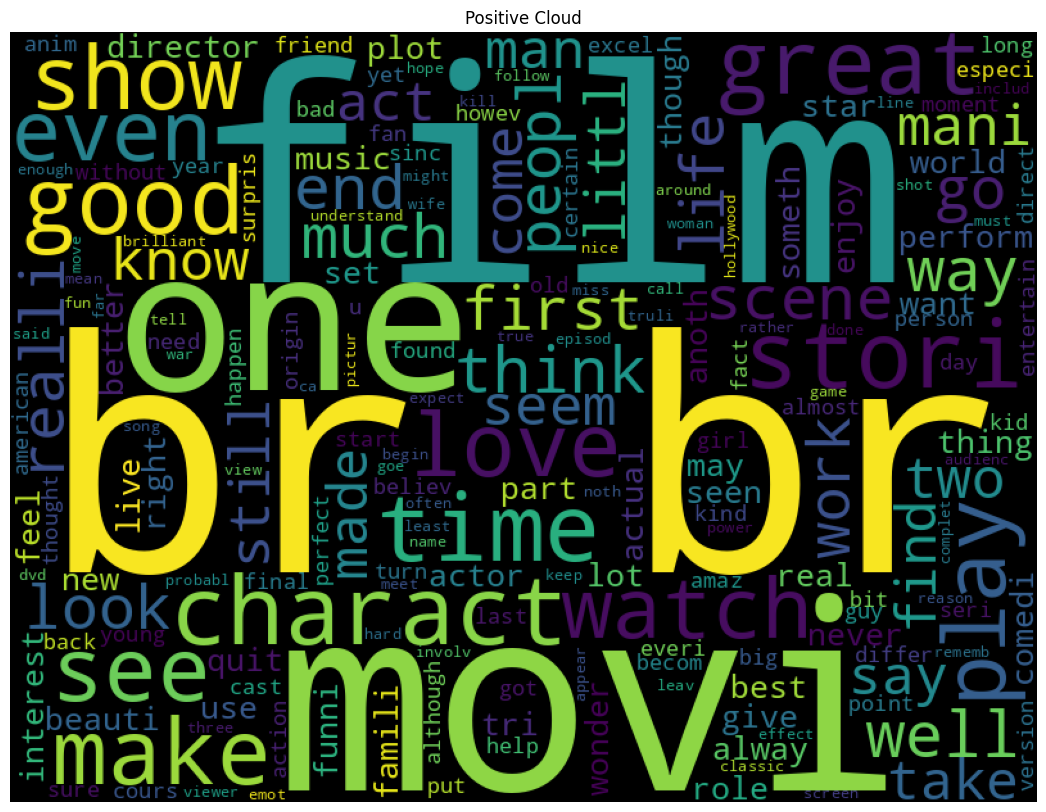

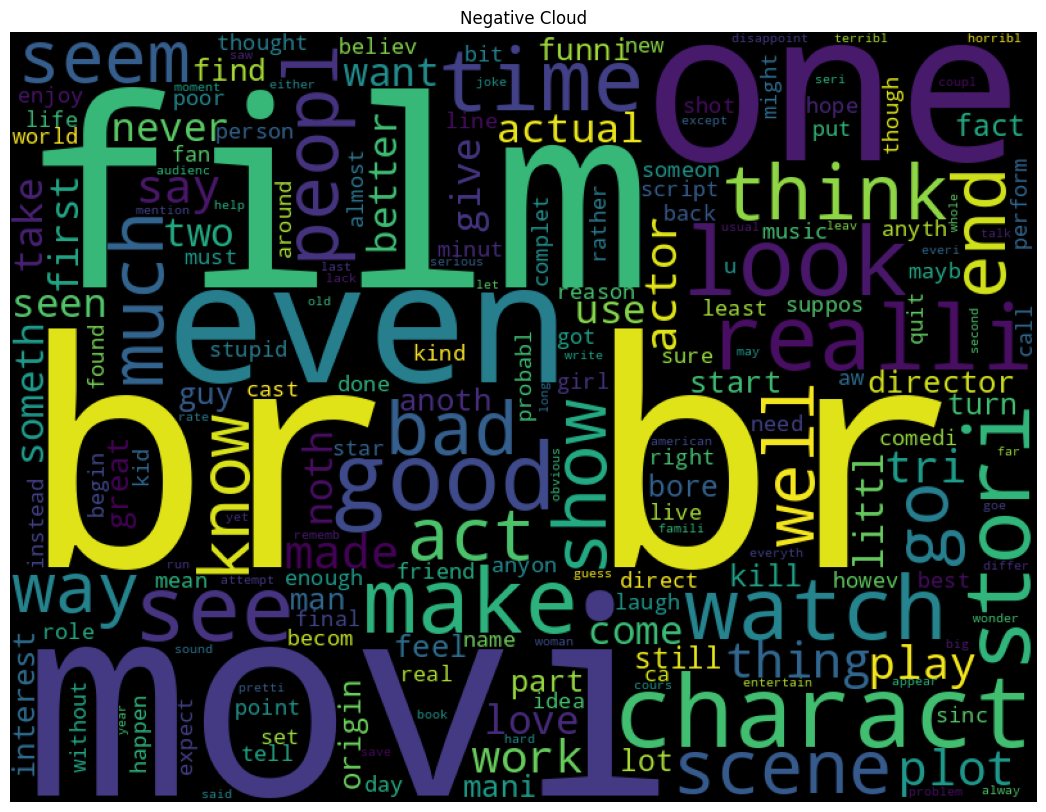

In [19]:
def plot_word_cloud(text: str, title: str):
    """Строит облако слов из текста text
    title -- заголовок для диаграммы"""
    wordcloud = WordCloud( width = 800, height = 600).generate(text)
    plt.figure(figsize = (15, 10))
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

plot_word_cloud(text_positive, 'Positive Cloud')
plot_word_cloud(text_negative, 'Negative Cloud')

## TF-IDF

In [20]:
# Создание TF-IDF матрицы
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), max_df=0.8, min_df=10)
X_tfidf = vectorizer.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

### Гиперпараметры

In [21]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [22]:
from numpy import absolute, mean, std
from sklearn.model_selection import cross_val_score


def model_cross_val_score(model, X, y, scorings, silent=False):        
    for scoring in scorings:            
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
        scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        scores = absolute(scores)
        if not silent:                    
            print(f"{scoring}: mean {mean(scores):1.4f} std {std(scores):1.4f}")                          

In [23]:
def grid_search(model_class, X, y, scoring, grid, silent=False):
    first_values_dict = {k: v[0] for k, v in grid.items()}
    model = model_class(**first_values_dict)    
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)        
    search = GridSearchCV(model, grid, scoring=scoring, cv=cv, n_jobs=-1)
    results = search.fit(X, y)
    if not silent:
        print(f"Best {scoring} score: {results.best_score_:1.4f}")
        print(f"Config: {results.best_params_}")
    return results.best_params_

In [24]:
def grid_search_w_cross_val(model, X, y, validate_scorings, grid_scoring, grid):
    print(f"Searching parameters for {model.__name__} model.")                    
    params = grid_search(model, X, y, scoring=grid_scoring, grid=grid)        
    print(f"\nValidation result: ")                
    model_cross_val_score(model(**params), X, y, scorings=validate_scorings)

In [25]:
lr_grid = dict()
lr_grid['max_iter'] = np.arange(150, 350, 50)
lr_grid['solver'] = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
lr_scorings = ['f1', 'accuracy']
lr_scoring = 'f1'

In [43]:
from numpy import arange

svc_grid = dict()
svc_grid['C'] = arange(2, 5, 1)
svc_grid['kernel'] = ['linear']
svc_scorings = ['f1', 'accuracy']
svc_scoring = 'f1'

In [65]:
nb_grid = dict()
nb_grid['alpha'] = arange(0, 1, 0.1)
nb_grid['force_alpha'] = [True, False]
nb_scorings = ['f1', 'accuracy']
nb_scoring = 'f1'

In [48]:
# Модели
models = [
    { 
        'model': LogisticRegression,
        'name': 'Logistic Regression',
        'grid_scoring': lr_scoring,
        'grid': lr_grid,
        'val_scoring': lr_scorings,
    },
    { 
        'model': MultinomialNB,
        'name': 'Naive Bayes',
        'grid_scoring': nb_scoring,
        'grid': nb_grid,
        'val_scoring': nb_scorings,
    },    
    { 
        'model': SVC,
        'name': 'Support Vector Machine',
        'grid_scoring': svc_scoring,
        'grid': svc_grid,
        'val_scoring': svc_scorings,
    },           
]

In [50]:
# Поиск параметров
for model in models:  
    if model['name'] == 'Support Vector Machine':
        pass
    else:
        grid_search_w_cross_val(model['model'], X_train, y_train, model['val_scoring'], model['grid_scoring'], model['grid'])

Searching parameters for LogisticRegression model.
Best f1 score: 0.8615
Config: {'max_iter': 150, 'solver': 'liblinear'}

Validation result: 
f1: mean 0.8615 std 0.0122
accuracy: mean 0.8563 std 0.0110
Searching parameters for MultinomialNB model.


/home/raiden/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/raiden/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/raiden/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/home/raiden/.local/lib/python3.11/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/raiden/.local/lib/python3.11/site-packages/sklearn/naive

Best f1 score: 0.8452
Config: {'alpha': 0.8}

Validation result: 
f1: mean 0.8452 std 0.0126
accuracy: mean 0.8424 std 0.0123


### Результат

In [51]:
# Модели
cmodels = [
    { 
        'model': LogisticRegression,
        'name': 'Logistic Regression',
        'config': {'max_iter': 250, 'solver': 'sag'}   # {'max_iter': 150, 'solver': 'liblinear'} # - на 5к отзывах
    },
    { 
        'model': SVC,
        'name': 'Support Vector Machine',
        'config': {'C': 2.0, 'kernel': 'linear'}
    },           
    { 
        'model': MultinomialNB,
        'name': 'Naive Bayes',
        'config': {'alpha': 0.9}        
    }     
]

In [52]:
# Обучение и оценка моделей
for item in cmodels:       
    m = item['model']
    model_name = item['name']
    config = item['config']
    model = m(**config)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")    

Model: Logistic Regression
Accuracy: 0.8480, Precision: 0.8502, Recall: 0.8480, F1-Score: 0.8478

Model: Support Vector Machine
Accuracy: 0.8340, Precision: 0.8355, Recall: 0.8340, F1-Score: 0.8339

Model: Naive Bayes
Accuracy: 0.8510, Precision: 0.8516, Recall: 0.8510, F1-Score: 0.8510



## word2vec

In [87]:
import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize

In [60]:
vectors = gensim.downloader.load('glove-twitter-25')

def preprocess_text2list(text):
    """ очищает и стеммит текст
    return: список слов """
    # список из слов потом можно использовать, чтобы сделать из него список векторов
    global vectors
    words = word_tokenize(text.lower())
    return [ stemmer.stem(word) for word in words if word.isalpha() and (word not in stop_words) and (word in vectors) ]   


data['review_lst'] = data[r].apply(preprocess_text2list)
data['tokenized_review'] = [[vectors[word] for word in text if word in vectors] for text in data['review_lst'].values]

33553    [[-0.11983, 1.3252, 0.1024, -1.0465, -0.89154,...
9427     [[-0.93624, 0.16686, 0.1408, 0.22105, -0.81805...
199      [[0.5823, -0.40719, 0.69944, -0.061546, 0.4505...
12447    [[0.15677, 0.070146, 0.88331, 0.64407, -1.5095...
39489    [[0.24481, 0.83835, -0.80329, -0.088691, -0.65...
                               ...                        
39885    [[0.39657, 0.15653, 0.50676, -0.039995, -0.117...
17566    [[0.078385, -0.40389, 0.80141, -0.44679, -0.22...
16062    [[-0.62645, -0.082389, 0.070538, 0.5782, -0.87...
48445    [[-0.56909, -0.005914, 0.40744, 0.10059, -0.56...
20382    [[-1.2112, 0.5699, 0.49154, 0.42618, 0.42084, ...
Name: tokenized_review, Length: 5000, dtype: object

In [62]:
def average_vec( vecs ):
    """ Считает средний вектор по списку 
    vecs -- список из numpy массивов"""
    
    aver = np.zeros( len(vecs[0]) )
    for i in range(len(vecs)):
        aver+= vecs[i]
    return aver/len(vecs)

X_vec = [average_vec(rev_vecs) for rev_vecs in data['tokenized_review'].values]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

### Результат

In [ ]:
from sklearn.naive_bayes import GaussianNB
 
# Модели
w2v_models = [
    { 
        'model': LogisticRegression,
        'name': 'Logistic Regression',
        'config': {'max_iter': 250, 'solver': 'sag'}   # {'max_iter': 150, 'solver': 'liblinear'} # - на 5к отзывах
    },
    { 
        'model': SVC,
        'name': 'Support Vector Machine',
        'config': {'C': 2.0, 'kernel': 'linear'}
    },           
    { 
        'model': GaussianNB,
        'name': 'GaussianNB',
        'config': {}
    }     
]

In [ ]:
# Обучение и оценка моделей
for item in w2v_models:       
    m = item['model']
    model_name = item['name']
    config = item['config']
    model = m(**config)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")    

Model: Logistic Regression
Accuracy: 0.7070, Precision: 0.7070, Recall: 0.7070, F1-Score: 0.7070

Model: Support Vector Machine
Accuracy: 0.7160, Precision: 0.7160, Recall: 0.7160, F1-Score: 0.7160

Model: GaussianNB
Accuracy: 0.6400, Precision: 0.6400, Recall: 0.6400, F1-Score: 0.6399



## Выводы 

#### TF-IDF

Преимущества:

* Простота реализации и интерпретации.
* Учитывает важность слова в документе, основываясь на его частоте в документе и обратной частоте 
* Хорошо работает для задач классификации текстов, анализа тональности и информационного извлечения.

Недостатки:

* Не учитывает семантическую связь между словами, поэтому может упустить важные смысловые аспекты текста.
* Ограниченный размер словаря может привести к потере информации.
* Не учитывает порядок слов в тексте, что может быть важным для некоторых задач.

#### Word2Vec

Преимущества:

* Учитывает семантическую связь между словами, что позволяет захватить смысловые аспекты текста.
* Можно выполнять поиск ближайших слов и арифметические операции над векторами.
* Работает лучше для слов, которые не встречались в обучающем наборе, благодаря контекстному обучению.

Недостатки:

* Более сложная реализация и обучение по сравнению с TF-IDF.
* Могут возникать проблемы с редкими словами или словами, которые не встречаются в обучающем наборе.
* Не учитывает порядок предложений или документов.

Существуют разные алгоритмы:
* FastText
* Glove
* Google News Vectors